In [1]:
import Pkg;

In [2]:
using Plots;
using Random;

In [3]:
# Testing Constants
NUM_DATA_POINTS = 100;
data = rand(Float64, (NUM_DATA_POINTS, 2));

In [4]:
mutable struct KMeans 
    num_centroids::Int64
    clusters::Array{Float64, 2}
    labels::Array{Int64, 1}
    
    # Constructor
    # Creates the random centers
    function KMeans(num_clusters::Int64)
        clusters = initialize_centroids(num_clusters)
        new(num_clusters, clusters, [])
    end
end

In [5]:
function initialize_centroids(num_centroids::Int64) 
   return rand(Float64, (num_centroids, 2))
end

initialize_centroids (generic function with 1 method)

In [6]:
function step!(k::KMeans, data::Array{Float64, 2}, d_cluster_pos::Dict{Int64, Array{Float64,1}})
    num_data_points::Int8 = size(data,1)
    num_clusters::Int8 = size(k.clusters,1)
    
    # Initialize the distance matrix as (num data points) x (number of clusters)
    data_centroid_dist = zeros(Float64, size(data,1), size(k.clusters,1))
    
    for i=1:num_clusters
        # Calculate the distances to each centroid for each data point
        data_centroid_dist[:,i] = broadcast(sqrt,(data[:,1] .- k.clusters[i,1]).^2 + (data[:,2] .- k.clusters[i,2]).^2)
    end
    
    # Get the labels from the distances
    min_dists = argmin(data_centroid_dist, dims=2);
    for i=1:size(min_dists,1)
        k.labels[i] = min_dists[i][2]
    end
    
    # If there is a variation problem this function
    # checks the length so when taking average
    # the result is 0 not NaN
    check_filtered_data_length(d) = return size(d,1) != 0 ? size(d,1) : 1
    
    for i=1:num_clusters
        # Filter the data to get data with cluster data
        mask = map(x -> x==i, k.labels)
        filtered_data = data[mask,:]
        
        # Take the average of the data with cluster label
        average_with_label = sum(filtered_data, dims=1) / check_filtered_data_length(filtered_data)
        # Find the distance from the average
        euclidean_dist = sqrt.(((average_with_label[:,1] .- k.clusters[i,1]).^2 + 
                               (average_with_label[:,2] .- k.clusters[i,2]).^2))[1]
        
        # Save the change in position 
        push!(d_cluster_pos[i], euclidean_dist)
        
        # Change the position of the centroid
        k.clusters[i,:] = average_with_label
    end
end

step! (generic function with 1 method)

In [7]:
function fit(k::KMeans, data::Array{Float64, 2}, iter_count::Int)
    variance::Array{Tuple{Float64, Array{Int64,1}, Array{Float64,2}, Dict{Int64, Array{Float64,1}}}} = []
    
    calculate_mean(labels) = return sum(labels) / length(labels)
    calculate_variance(labels) = return sum((labels .- calculate_mean(labels)).^2) / length(labels)
    
    for test_num=1:10
        # Initialize the labels and change in centroid position dictionary
        k.labels = zeros(Int8, size(data,1))
        d_cluster_pos = Dict{Int64, Array{Float64,1}}([(i, []) for i=1:size(k.clusters,1)])
        # Randomize new centroid coords
        k.clusters = test_num != 1 ? initialize_centroids(k.num_centroids) : k.clusters
        # Find centroids by iteration
        for i=1:iter_count
            step!(k, data, d_cluster_pos)
        end
        # Save the variance, labels, centroids generated
        # Will use the lowest variance to find best outcome
        push!(variance, (calculate_variance(k.labels), k.labels, k.clusters, d_cluster_pos))
    end

    # Test set with lowest variance
    best_test_index = argmin(first.(variance[:,1]))

    # Plot the changes in position of the centroids for test with least variation
    plt_delta_cluster_pos = plot(get(variance[best_test_index][4], 1, []), xlims=(0,iter_count))
    xlabel!(plt_delta_cluster_pos, "Iteration count")
    ylabel!(plt_delta_cluster_pos, "Change in position")
    title!(plt_delta_cluster_pos, "Position Change of Centroids")
    for i=2:size(k.clusters,1)
        plot!(plt_delta_cluster_pos, get(variance[best_test_index][4], i, []))
    end
    
    # Plot the final clustered data
    data_label_mask(cluster_index) = return map(x -> x==cluster_index, variance[best_test_index][2])
    plt_clusters = scatter(data[data_label_mask(1),1], data[data_label_mask(1),2])
    title!(plt_clusters, "Clustered Data")
    for i=2:size(k.clusters,1)
        scatter!(plt_clusters, data[data_label_mask(i),1], data[data_label_mask(i),2])
    end
    scatter!(plt_clusters, variance[best_test_index][3][:,1], variance[best_test_index][3][:,2], 
        marker=:x, markersize=8, markercolor=:black)
   
    # Create final plot with 2 subplots in layout
    plot(plt_clusters, plt_delta_cluster_pos, layout=(2, 1))
end

fit (generic function with 1 method)

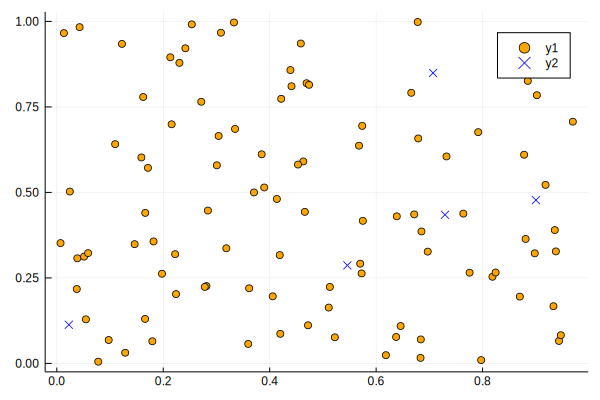

In [8]:
kmeans = KMeans(5);

# Data without being clustered and first centroids plotted
plt = plot(data[:,1], data[:,2], seriestype=scatter, markercolor=:orange)
scatter!(plt, kmeans.clusters[:,1], kmeans.clusters[:,2], markercolor=:blue, marker=:x)

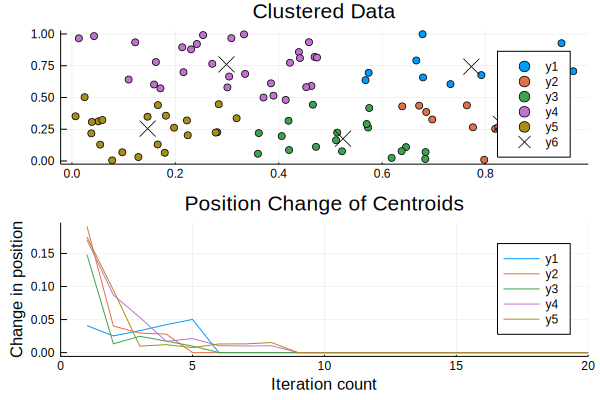

In [9]:
fit(kmeans, data, 20)